In [1]:
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import scipy as sc
import pandas as pd
import numpy as np
import time
from sklearn.metrics import *
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from keras.losses import binary_crossentropy
from keras.layers import Dense, Flatten, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import r2_score
from keras import backend as K
from sklearn.model_selection import train_test_split

In [4]:
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [5]:
data_dir = 'https://github.com/henrii1/Wind-Turbine-power-prediction-and-monitoring-using-XGboost-and-quantile-regression/blob/main/data/kelmarsh_02.xlsx?raw=true'
data = pd.read_excel(data_dir)
data.isna().sum()

def outlier_remover(dat, prop, min, max):
    d = dat
    q_low = d[prop].quantile(min)
    q_high = d[prop].quantile(max)
    return d[(d[prop]<q_high) & (d[prop]>q_low)]

d1 = {}
step = 50
i = 1
for x in range(20, 3100, step):
    d1[i] = data.iloc[((data['power']>=x)& (data['power']<x+step)).values]
    i = i + 1

d1[-2] = data.iloc[(data['power']>=2900).values]

for x in range(1, 62):
    if x <= 3:
        F = 0.95
    elif ((x > 3) and (x <= 10)):
        F = 0.9
    elif ((x > 10) and (x <= 20)):
        F = 0.92
    elif ((x > 20) and (x <= 30)):
        F = 0.96
    else:
        F = 0.985
    d1[x] = outlier_remover(d1[x], 'wind speed', 0.00001, F)


df = pd.DataFrame()
for infile in range (1, 62):
    data = d1[infile]
    df = df.append(data, ignore_index = True)




In [6]:
da = df.drop(columns=['date'])
da.dropna()
scaler = MinMaxScaler(feature_range =(0, 1))
data_ = scaler.fit_transform(da)
data_1 = np.array(da)
data_x_ = data_1[:, :-1]
data_y_ = data_1[:, -1]
data_x = data_[:, :-1]
data_y = data_[:, -1]

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.001, random_state = 1)
x_train_, x_test_, y_train_, y_test_ = train_test_split(data_x_, data_y_, test_size = 0.001, random_state = 1)

In [7]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    print(f'xgboost_RMSE:{rmse}')
    print(f'xgboost_MAE:{mae}')
    print(f'xgboost_R_SCORE:{r2}')

In [8]:
best_xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)


best_xgb_model.fit(x_train_,y_train_)
pred1 = best_xgb_model.predict(x_test_)

xgboost_model = eval_metrics(y_test_, pred1)
print(f' xgboost cummulative accuracy is: {xgboost_model}')

[22:50:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
xgboost_RMSE:50.72159063035891
xgboost_MAE:39.87677118086397
xgboost_R_SCORE:0.9954205086991087
 xgboost cummulative accuracy is: None


In [9]:
best_xgb_model_ = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)
best_xgb_model_.fit(x_train,y_train)
pred1_ = best_xgb_model_.predict(x_test)

#xgboost_model_ = eval_metrics(y_test_, pred1_)
#print(f' xgboost cummulative accuracy is: {xgboost_model}')

[22:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [10]:
print(f'the ground truth result is: {y_test_}')

the ground truth result is: [1632.98130188   40.90395051 1955.60958862 1940.41240845 2036.59888916
 1952.80290985  138.09537747 2007.07867025  652.25278015 1842.5414917
 2057.21834717 1102.48840942  347.71608353  238.38979416  204.43778152
 1050.54462891  782.04765015  484.25324478 1266.57329359  103.44570084
 1173.66550293   28.44322672  144.32294464 1735.75958252   81.79648751
  566.1793552   167.42646713 2057.29093018   54.64244995 1355.70979004
  631.17392578  327.38682476 1977.54632568  142.44975233 2050.24880981
  491.58210995  216.80513787  417.49911804  327.8371582   700.69975128
  477.39680023  341.16752167  319.53642578 2041.31426392]


In [11]:
print(f'the ground truth result is: {y_test}')

the ground truth result is: [0.78256331 0.01013892 0.93909211 0.93171893 0.97838549 0.9377304
 0.05729306 0.96406324 0.30674558 0.88423513 0.98838939 0.52518533
 0.15899424 0.10595266 0.08948024 0.49998389 0.36971785 0.22523765
 0.604794   0.04048216 0.55971815 0.00409338 0.06031447 0.832428
 0.02997866 0.26498554 0.07152355 0.9884246  0.0168044  0.64804015
 0.2965188  0.14913114 0.9497351  0.05940566 0.98500799 0.22879337
 0.09548048 0.19285071 0.14934963 0.33025048 0.22191112 0.15581709
 0.14532238 0.98067324]


In [12]:
print(f"xgboost predicted results is: {pred1_}")

xgboost predicted results is: [ 8.29985440e-01  1.77671611e-02  9.56698060e-01  9.61145520e-01
  9.46979105e-01  9.48828697e-01  6.03212416e-02  9.85562801e-01
  3.29594433e-01  9.06087399e-01  9.80348229e-01  5.13096571e-01
  1.51456267e-01  1.30639166e-01  8.83782506e-02  5.34057379e-01
  4.02792037e-01  2.07528979e-01  5.35880804e-01  7.01160431e-02
  6.09420657e-01 -4.75645065e-04  5.09648025e-02  7.93050408e-01
  2.49950886e-02  2.27256447e-01  9.86234546e-02  9.77386892e-01
  1.02862120e-02  6.48894072e-01  2.86471635e-01  1.75332725e-01
  9.29428935e-01  5.14818132e-02  9.83720958e-01  2.13099808e-01
  1.09760076e-01  1.88424677e-01  1.32155061e-01  3.44749600e-01
  2.63763487e-01  1.92096978e-01  1.46066099e-01  9.74765480e-01]


In [13]:
model1_1A = Sequential()
model1_1A.add(Dense(128, input_dim = (3)))
model1_1A.add(RBFLayer(64, 0.5))
model1_1A.add(Dense(1, activation='sigmoid', name= 'output'))
model1_1A.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 rbf_layer (RBFLayer)        (None, 64)                8192      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


In [14]:
model1_1A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

In [15]:
rbf_model = model1_1A.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1)


rbf_pred1 = model1_1A.predict(x_test)
r2=r2_score(y_test, rbf_pred1)
print(r2)

Epoch 1/50
868/868 [==============================] - 5s 5ms/step - loss: 0.4316 - root_mean_squared_error: 0.0780 - mean_absolute_error: 0.0423
Epoch 2/50
868/868 [==============================] - 4s 5ms/step - loss: 0.4180 - root_mean_squared_error: 0.0334 - mean_absolute_error: 0.0252
Epoch 3/50
868/868 [==============================] - 4s 5ms/step - loss: 0.4177 - root_mean_squared_error: 0.0327 - mean_absolute_error: 0.0246
Epoch 4/50
868/868 [==============================] - 4s 5ms/step - loss: 0.4175 - root_mean_squared_error: 0.0323 - mean_absolute_error: 0.0242
Epoch 5/50
868/868 [==============================] - 4s 5ms/step - loss: 0.4174 - root_mean_squared_error: 0.0320 - mean_absolute_error: 0.0239
Epoch 6/50
868/868 [==============================] - 4s 5ms/step - loss: 0.4173 - root_mean_squared_error: 0.0317 - mean_absolute_error: 0.0236
Epoch 7/50
868/868 [==============================] - 4s 5ms/step - loss: 0.4172 - root_mean_squared_error: 0.0314 - mean_absolute

In [16]:
print(f"the rbf predicted result is: {rbf_pred1}")

the rbf predicted result is: [[0.819788  ]
 [0.02096564]
 [0.9539627 ]
 [0.9642532 ]
 [0.9516089 ]
 [0.94001406]
 [0.07563806]
 [0.9897281 ]
 [0.332688  ]
 [0.90196097]
 [0.98349094]
 [0.51494974]
 [0.15309784]
 [0.12461171]
 [0.10058257]
 [0.5384451 ]
 [0.4002019 ]
 [0.20670342]
 [0.5155479 ]
 [0.06104651]
 [0.6227179 ]
 [0.01997179]
 [0.06656006]
 [0.78231907]
 [0.04103041]
 [0.23371151]
 [0.09676987]
 [0.9847109 ]
 [0.01900515]
 [0.6569649 ]
 [0.2849282 ]
 [0.18530574]
 [0.9313104 ]
 [0.0538733 ]
 [0.9867643 ]
 [0.22250682]
 [0.10878748]
 [0.18667951]
 [0.14099741]
 [0.34008098]
 [0.26026732]
 [0.19326475]
 [0.1549862 ]
 [0.9744109 ]]


In [17]:
model1_2A = Sequential()
model1_2A.add(Dense(3, activation='relu', input_dim=(3)))
model1_2A.add(Dense(32, activation='relu'))
model1_2A.add(Dense(64, activation='relu'))
model1_2A.add(Dense(64, activation='relu'))
model1_2A.add(Dense(32, activation='relu'))
model1_2A.add(Dense(1, name='output'))
model1_2A.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 32)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 output (Dense)              (None, 1)                 33        
                                                                 
Total params: 8,525
Trainable params: 8,525
Non-traina

In [18]:
model1_2A.compile(optimizer='adam',
              loss=binary_crossentropy,
              metrics=[
                       tf.keras.metrics.RootMeanSquaredError(),
                       tf.keras.metrics.MeanAbsoluteError(),
                       ])

mlp_model = model1_2A.fit(x_train, y_train, epochs=50, batch_size=50, verbose=1)

y_pred1_2A = model1_2A.predict(x_test)


Epoch 1/50
868/868 [==============================] - 3s 2ms/step - loss: 0.4610 - root_mean_squared_error: 0.1351 - mean_absolute_error: 0.0814
Epoch 2/50
868/868 [==============================] - 2s 2ms/step - loss: 0.4411 - root_mean_squared_error: 0.0895 - mean_absolute_error: 0.0522
Epoch 3/50
868/868 [==============================] - 2s 2ms/step - loss: 0.4394 - root_mean_squared_error: 0.0812 - mean_absolute_error: 0.0515
Epoch 4/50
868/868 [==============================] - 2s 2ms/step - loss: 0.4305 - root_mean_squared_error: 0.0570 - mean_absolute_error: 0.0360
Epoch 5/50
868/868 [==============================] - 2s 2ms/step - loss: 0.4303 - root_mean_squared_error: 0.0617 - mean_absolute_error: 0.0345
Epoch 6/50
868/868 [==============================] - 2s 2ms/step - loss: 0.4288 - root_mean_squared_error: 0.0567 - mean_absolute_error: 0.0352
Epoch 7/50
868/868 [==============================] - 2s 2ms/step - loss: 0.4230 - root_mean_squared_error: 0.0544 - mean_absolute

In [19]:
r2_mlp = r2_score(y_test, y_pred1_2A)
print(r2_mlp)

0.9948554462277333


In [20]:
print(f" the predicted values for the mlp model is: {y_pred1_2A}")

 the predicted values for the mlp model is: [[0.8334561 ]
 [0.01201795]
 [0.94477683]
 [0.95142215]
 [0.94491976]
 [0.94461966]
 [0.06093323]
 [0.9699126 ]
 [0.3254608 ]
 [0.89601797]
 [0.9722433 ]
 [0.5088306 ]
 [0.14545554]
 [0.10934487]
 [0.08600478]
 [0.533291  ]
 [0.39678812]
 [0.19846845]
 [0.51721036]
 [0.05034397]
 [0.61613476]
 [0.01577973]
 [0.05060352]
 [0.7808688 ]
 [0.02790563]
 [0.22424486]
 [0.07881018]
 [0.97478956]
 [0.01220185]
 [0.65280867]
 [0.2769228 ]
 [0.16767496]
 [0.9188332 ]
 [0.04496973]
 [0.97110826]
 [0.20464271]
 [0.09267142]
 [0.17240098]
 [0.12641351]
 [0.33620605]
 [0.25504264]
 [0.18275362]
 [0.1484989 ]
 [0.9552694 ]]


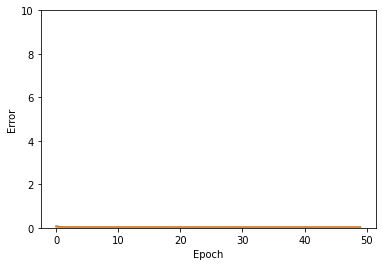

In [21]:
def plot_loss(rbf_model):
  plt.plot(rbf_model.history['root_mean_squared_error'], label='rmse')
  plt.plot(rbf_model.history['mean_absolute_error'], label='mae')
  #plt.plot(r2.history['r2'], label='r2')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(rbf_model)

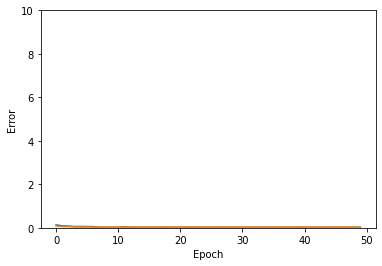

In [22]:
def plot_loss(mlp_model):
  plt.plot(mlp_model.history['root_mean_squared_error'], label='rmse')
  plt.plot(mlp_model.history['mean_absolute_error'], label='mae')
 # plt.plot(r2_mlp.history['r2'], label='r2')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')

plot_loss(mlp_model)

In [23]:
xgboost_predicted = best_xgb_model.predict(data_x_)

In [24]:
rbf_predicted = model1_1A.predict(data_x)

In [25]:
mlp_predicted = model1_2A.predict(data_x)

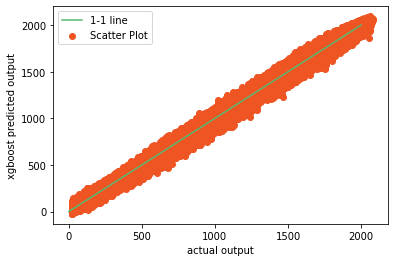

In [26]:
#plt.plot(1, 1, color='#58b970', label='1-1 line')
x = [0, 500, 1000, 1500, 2000]
y = [0, 500, 1000, 1500, 2000]
plt.plot(x, y, color='#58b970', label='1-1 line')
plt.scatter(data_y_, xgboost_predicted, c='#ef5423', label='Scatter Plot')

plt.xlabel('actual output')
plt.ylabel('xgboost predicted output')
plt.legend()
plt.show()

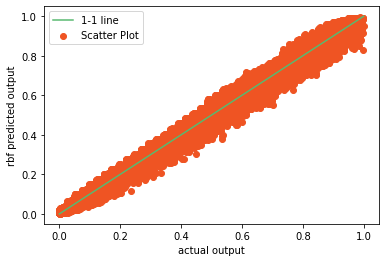

In [27]:
x = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
y = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
plt.plot(x, y, color='#58b970', label='1-1 line')

plt.scatter(data_y, rbf_predicted, c='#ef5423', label='Scatter Plot')

plt.xlabel('actual output')
plt.ylabel('rbf predicted output')
plt.legend()
plt.show()

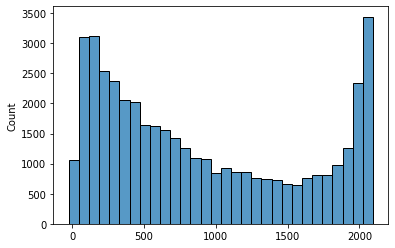

In [28]:
import seaborn as sns
sns.histplot(xgboost_predicted)

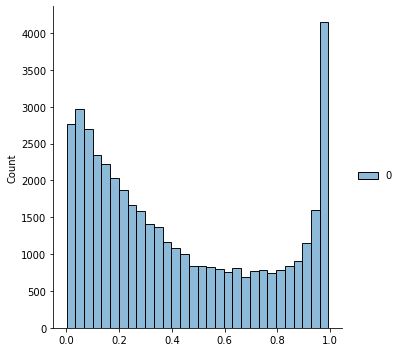

In [29]:
sns.displot(rbf_predicted)

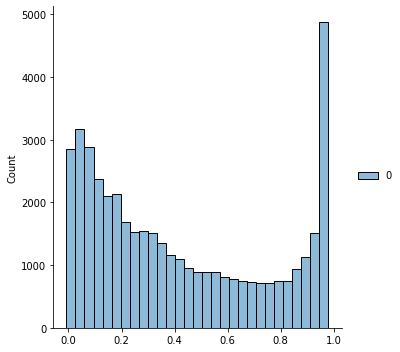

In [30]:
sns.displot(mlp_predicted)

In [31]:
d = {'wind speed': data_x_[:, 0], 'power output':xgboost_predicted }
e = pd.DataFrame(data=d)
e

,wind speed,power output
0,3.047361,98.183426
1,2.652139,73.429146
2,3.426296,122.242455
3,2.766799,59.306686
4,2.966572,76.206795
...,...,...
43409,12.532399,2044.529785
43410,13.545566,2047.304321
43411,13.648132,2042.839722
43412,12.969924,2045.875854


In [32]:
from pandas import ExcelWriter

writer = ExcelWriter('model_data_1.xlsx')
e.to_excel(writer)
writer.save()

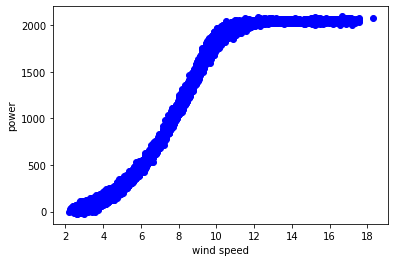

In [33]:
plt.scatter(e[['wind speed']], e[['power output']], color = 'b')
plt.xlabel("wind speed")
plt.ylabel("power")
plt.show()